# Sommaire
<a id="sommaire"></a>
* 0. Présentation générale du webinar
    * Présentation de la Data Science et du Machine Learning
    * Présentation de l'Analyse de Données Exploratoire
    * Présentation de Kaggle
    * Présentation de la compétition Kaggle
* [1. Introduction](#1)
* [2. Généralités](#2)
    * [2.1. Nombre de lignes et colonnes](#2.1)
    * [2.2. Nombre de valeurs manquantes](#2.2)
    * [2.3. 5 premières lignes](#2.3)
    * [2.4. Statistiques basiques sur les variables continues](#2.4)
    * [2.5. Comptage sur les variables catégorielles](#2.5)
    * [2.6. Variables cibles](#2.6)
* [3. Relation entre features et variable cible](#3)
    * [3.1. Variables continues](#3.1)
    * [3.2. Variables catégorielles](#3.2)
* [4. Modèle baseline](#4)
    * [4.1 Préparation](#4.1)
    * [4.2 Catboost](#4.2)
    * [4.3 XGBoost](#4.3)
    * [4.4 LGBM](#4.4)
    * [4.5 Modèle moyenné](#4.5)
* [5. Modèlé fine-tuné](#5)
    * [5.1 Catboost](#5.1)
    * [5.2 XGBoost](#5.2)
    * [5.3 LGBM](#5.3)
    * [5.4 Modèle moyenné et fine-tuné](#5.4)

[back to top](#sommaire)
<a id="1"></a>
# 1. Introduction

Compétition Kaggle un peu plus simple, basé sur des données synthétiques, tabulaires.

[back to top](#table-of-contents)
<a id="2"></a>
# 2. Généralités

**Observations:**

* Le jeu `Train` a 300,000 lignes tandis que le jeu `test` a 200,000 lignes.
* Il y a 19 variables catégorielles `cat0` - `cat18` et 11 variables continues `cont0` - `cont10` pour un total de 30 features.
* Pas de valeurs manquantes.
* Les variables continues vont de -0.03 to 1 avec une distribution multimodale similaire entre le train et le test.
* Corrélation entre les variables continues:
    * `cont1` a la plus haute corrélation avec `cont2` avec une corrélation de 0.9.
    * `cont10` a une corrélation de 0.8 avec `cont0` et `cont7`.
    * Les variables continues qui ont une corrélation de 0.7 entre elles sont :
        * `cont0` et `cont7`
        * `cont8` et `cont1`
        * `cont8` et `cont2`
* Les variables `catégorielles`dans le `train` et le `test` sont similaires entre elles. Les variables catégorielles possédant plus de 50 catégories sont les suivantes:  
    * `cat5` a 84 catégories, `BI` étant la catégorie majoritaire avec une proportion autour de 79% suivie par `AB` qui a une proportion autour de 14%.
    * `cat7` a 51 catégories avec `AH`, `E` et `AS` étant le top 3 des catégories ayant une proportion de 15%, 13% et 8% respectivement. La proportion totale sur le top 20 catégories est autour de 87%.
    * `cat8` a 61 catégories avec `BM`, `AE` et `AX` étant le top 3 des catégories avec une proportion de 14.1%, 8.1% et 7.4% respectivement. La proportion totale sur le top 20 catégories est autour de 87% comme `cat7`.
    * `cat10` a 61 catégories avec `DJ`, `HK` et `DP` étant le top 3 des catégories avec une proportion de 10.5%, 10.3% et 7.9% respectivement. La proportion totale sur le top 20 catégories est autour de 73%.
* Les catégories de `cat10` sont différentes entre `train` et `test` : `train` a 299 catégories et `test` a 295 catégories, les catégories `BS`, `JF`, `CH`, `MW`, `AW`, `FW`, `MO`, `MK`, `IL`, `GH`, `CX`, `LK` ne se trouvent pas dans `test` et `KM`, `BW`, `EJ`, `BU`, `CA`, `JM`, `DG`, `KE` ne se trouvent pas dans `train`.
* La variable cible est déséquilibrée : la valeur `0` est présente à 73,5% alors que la valeur `1` est présente à 26.5%. Il faudra donc faire attention lors de la cross-validation.

In [1]:
import os
import joblib
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
cat_features = [feature for feature in train_df.columns if 'cat' in feature]
cont_features = [feature for feature in train_df.columns if 'cont' in feature]

[back to top](#sommaire)
<a id="2.1"></a>
## 2.1. Nombre de lignes et de colonnes

In [4]:
print('Rows and Columns in train dataset:', train_df.shape)
print('Rows and Columns in test dataset:', test_df.shape)

Rows and Columns in train dataset: (300000, 32)
Rows and Columns in test dataset: (200000, 31)


[back to top](#sommaire)
<a id="2.2"></a>
## 2.2. Nombre de valeurs manquantes

In [5]:
print('Missing values in train dataset:', sum(train_df.isnull().sum()))
print('Missing values in test dataset:', sum(test_df.isnull().sum()))

Missing values in train dataset: 0
Missing values in test dataset: 0


[back to top](#sommaire)
<a id="2.3"></a>
## 2.3. 5 premières lignes

**First 5 rows in the train dataset**

In [6]:
train_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,A,LO,A,A,A,A,B,D,D,B,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,F,HJ,A,B,A,B,D,B,D,B,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,L,DJ,A,B,A,A,B,D,D,B,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,F,KV,A,A,A,A,B,D,D,B,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,A,DP,A,A,A,B,B,B,D,B,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


**First 5 rows in the test dataset**

In [7]:
test_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
0,5,A,F,A,A,F,BI,A,AH,AX,A,LF,A,A,A,A,B,D,D,B,0.708120,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.947489
1,6,A,H,C,A,E,AB,I,F,N,A,MC,A,A,A,B,D,B,D,B,0.611637,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580
2,8,A,N,C,A,F,AB,A,AH,BC,A,FN,A,A,A,B,B,D,D,B,0.456289,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592
3,9,B,L,C,A,F,BI,A,E,AX,A,HK,A,A,A,A,B,D,B,B,0.338692,0.666092,0.598943,0.561971,0.806347,0.735983,0.538724,0.381566,0.481660,0.348514,0.325723
4,11,A,F,A,B,F,BI,A,AH,I,A,HX,A,A,A,A,D,D,D,B,0.631671,0.772229,0.479572,0.767745,0.252454,0.354810,0.178920,0.763479,0.562491,0.466261,0.585781


[back to top](#sommaire)
<a id="2.4"></a>
## 2.4. Statistiques basiques sur les variables continues
**Train dataset**

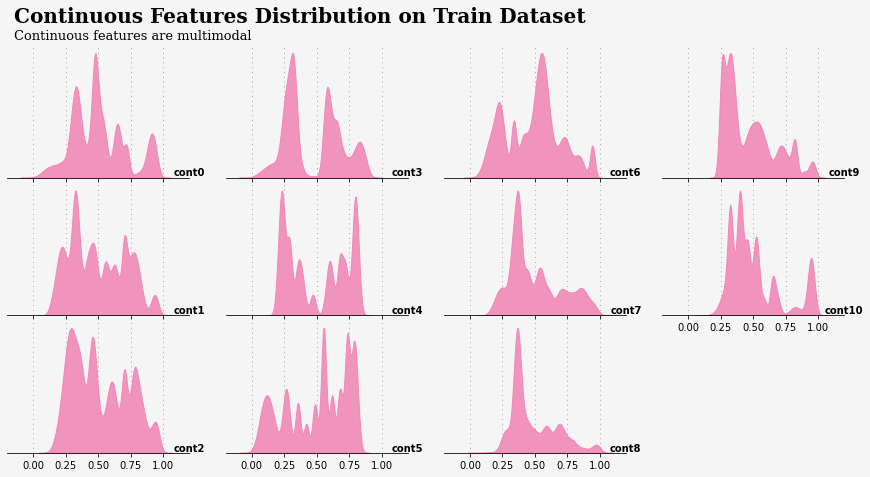

In [8]:
fig = plt.figure(figsize=(15, 10), facecolor='#f6f5f5')
gs = fig.add_gridspec(4, 4)
gs.update(wspace=0.2, hspace=0.05)

background_color = "#f6f5f5"

run_no = 0
for col in range(0, 4):
    for row in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        locals()["ax"+str(run_no)].set_yticklabels([])
        locals()["ax"+str(run_no)].tick_params(axis='y', which=u'both',length=0)
        for s in ["top", "right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.15, 4.5, 'Continuous Features Distribution on Train Dataset', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.15, 4, 'Continuous features are multimodal', fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cont_features:
    sns.kdeplot(train_df[col], ax=locals()["ax"+str(run_no)], shade=True, color='#f088b7', alpha=0.9, zorder=2)
    locals()["ax"+str(run_no)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    locals()["ax"+str(run_no)].set_ylabel(col, fontsize=10, fontweight='bold').set_rotation(0)
    locals()["ax"+str(run_no)].yaxis.set_label_coords(1, 0)
    locals()["ax"+str(run_no)].set_xlim(-0.2, 1.2)
    locals()["ax"+str(run_no)].set_xlabel('')
    run_no += 1
    
ax11.remove()

In [9]:
train_df[cont_features].describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.504749,0.494073,0.516632,0.474235,0.504848,0.502257,0.488229,0.501739,0.488074,0.469496,0.508230
std,0.206788,0.213037,0.214851,0.216636,0.227474,0.241243,0.211335,0.203496,0.179048,0.194516,0.203393
min,-0.049562,0.084480,0.094493,-0.045316,0.168071,-0.036379,0.005199,0.090901,0.024139,0.214866,0.097789
25%,0.344985,0.317363,0.326047,0.292249,0.279303,0.276442,0.323914,0.353054,0.358915,0.309934,0.368312
50%,0.479650,0.463170,0.471247,0.387564,0.479858,0.554768,0.518089,0.435404,0.410908,0.407477,0.446576
75%,0.637657,0.693992,0.704625,0.644950,0.725779,0.735225,0.608537,0.642023,0.612725,0.586793,0.581957
max,1.004559,1.009958,1.016600,0.952187,0.858578,0.853022,0.966553,1.035818,1.055885,1.005652,1.011331


**Test dataset**

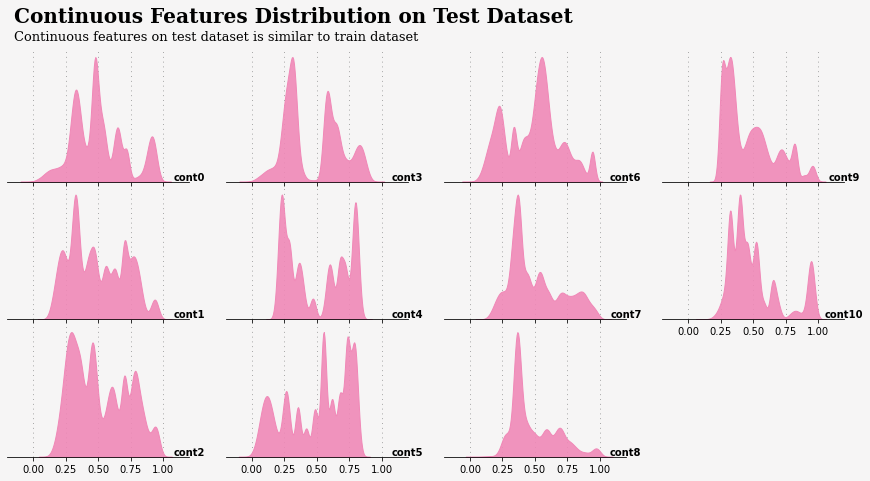

In [10]:
fig = plt.figure(figsize=(15, 10), facecolor='#f6f5f5')
gs = fig.add_gridspec(4, 4)
gs.update(wspace=0.2, hspace=0.05)

background_color = "#f6f5f5"

run_no = 0
for col in range(0, 4):
    for row in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        locals()["ax"+str(run_no)].set_yticklabels([])
        locals()["ax"+str(run_no)].tick_params(axis='y', which=u'both',length=0)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.15, 4.5, 'Continuous Features Distribution on Test Dataset', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.15, 4, 'Continuous features on test dataset is similar to train dataset', fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cont_features:
    sns.kdeplot(test_df[col], ax=locals()["ax"+str(run_no)], shade=True, color='#f088b7', alpha=0.9, zorder=2)
    locals()["ax"+str(run_no)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    locals()["ax"+str(run_no)].set_ylabel(col, fontsize=10, fontweight='bold').set_rotation(0)
    locals()["ax"+str(run_no)].yaxis.set_label_coords(1, 0)
    locals()["ax"+str(run_no)].set_xlim(-0.2, 1.2)
    locals()["ax"+str(run_no)].set_xlabel('')
    run_no += 1
    
ax11.remove()

In [11]:
test_df[cont_features].describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.505388,0.493960,0.516425,0.475286,0.504772,0.501180,0.487315,0.502684,0.488331,0.469813,0.508974
std,0.207417,0.212695,0.214752,0.216919,0.227199,0.241375,0.211335,0.203793,0.178895,0.194999,0.203926
min,-0.044929,0.090478,0.098591,-0.038178,0.171321,-0.036337,-0.005648,0.096067,0.013554,0.215540,0.113059
25%,0.344748,0.317788,0.326210,0.292777,0.279413,0.275422,0.322365,0.353388,0.359121,0.309888,0.368999
50%,0.479633,0.463195,0.470893,0.392118,0.480299,0.554723,0.517318,0.436139,0.411318,0.407066,0.446578
75%,0.638773,0.693882,0.704745,0.645803,0.725272,0.735137,0.607454,0.646104,0.612508,0.588008,0.583082
max,1.006825,1.011597,1.012128,0.965609,0.867198,0.848617,0.964635,1.033760,1.053155,1.007189,1.007168


**Correlation between continuous variables**

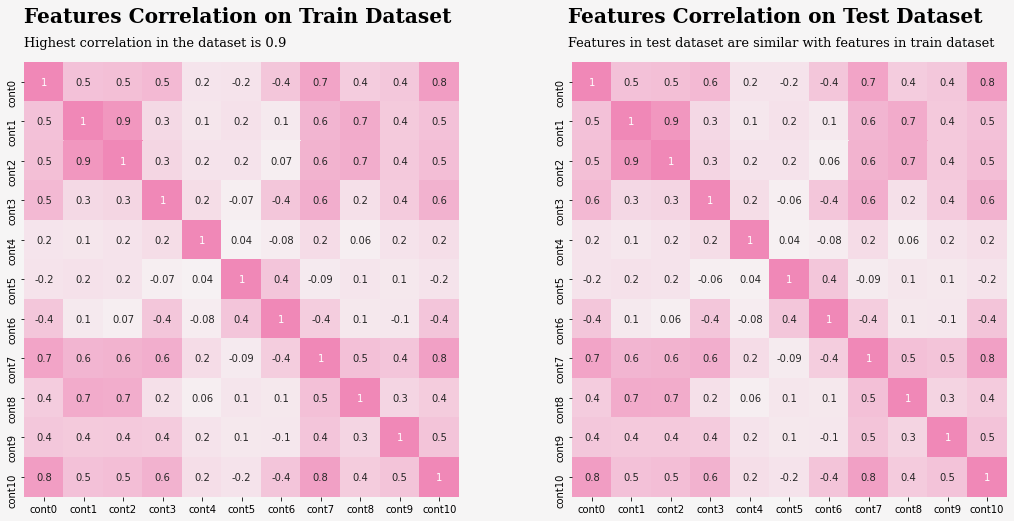

In [12]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(18, 8), facecolor=background_color)
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
colors = ["#f088b7", "#f6f5f5","#f088b7"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

ax0.set_facecolor(background_color)
ax0.text(0, -1, 'Features Correlation on Train Dataset', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(0, -0.4, 'Highest correlation in the dataset is 0.9', fontsize=13, fontweight='light', fontfamily='serif')

ax1.set_facecolor(background_color)
ax1.text(-0.1, -1, 'Features Correlation on Test Dataset', fontsize=20, fontweight='bold', fontfamily='serif')
ax1.text(-0.1, -0.4, 'Features in test dataset are similar with features in train dataset ', 
         fontsize=13, fontweight='light', fontfamily='serif')

sns.heatmap(train_df[cont_features].corr(), ax=ax0, vmin=-1, vmax=1, annot=True, square=True, 
            cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap, fmt='.1g')

sns.heatmap(test_df[cont_features].corr(), ax=ax1, vmin=-1, vmax=1, annot=True, square=True, 
            cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap, fmt='.1g')

plt.show()

[back to top](#sommaire)
<a id="2.5"></a>
## 2.5. Proportion des variables catégorielles
**Train dataset**

In [13]:
cat5_category = list(pd.DataFrame(train_df['cat5'].value_counts()/len(train_df['cat5'])*100)[:2].index)
cat7_category = list(pd.DataFrame(train_df['cat7'].value_counts()/len(train_df['cat7'])*100)[:13].index)
cat8_category = list(pd.DataFrame(train_df['cat8'].value_counts()/len(train_df['cat8'])*100)[:13].index)
cat10_category = list(pd.DataFrame(train_df['cat10'].value_counts()/len(train_df['cat10'])*100)[:13].index)
train_df['cat5'] = np.where(~train_df['cat5'].isin(cat5_category), 'Others', train_df['cat5'])
train_df['cat7'] = np.where(~train_df['cat7'].isin(cat7_category), 'Others', train_df['cat7'])
train_df['cat8'] = np.where(~train_df['cat8'].isin(cat8_category), 'Others', train_df['cat8'])
train_df['cat10'] = np.where(~train_df['cat10'].isin(cat10_category), 'Others', train_df['cat10'])

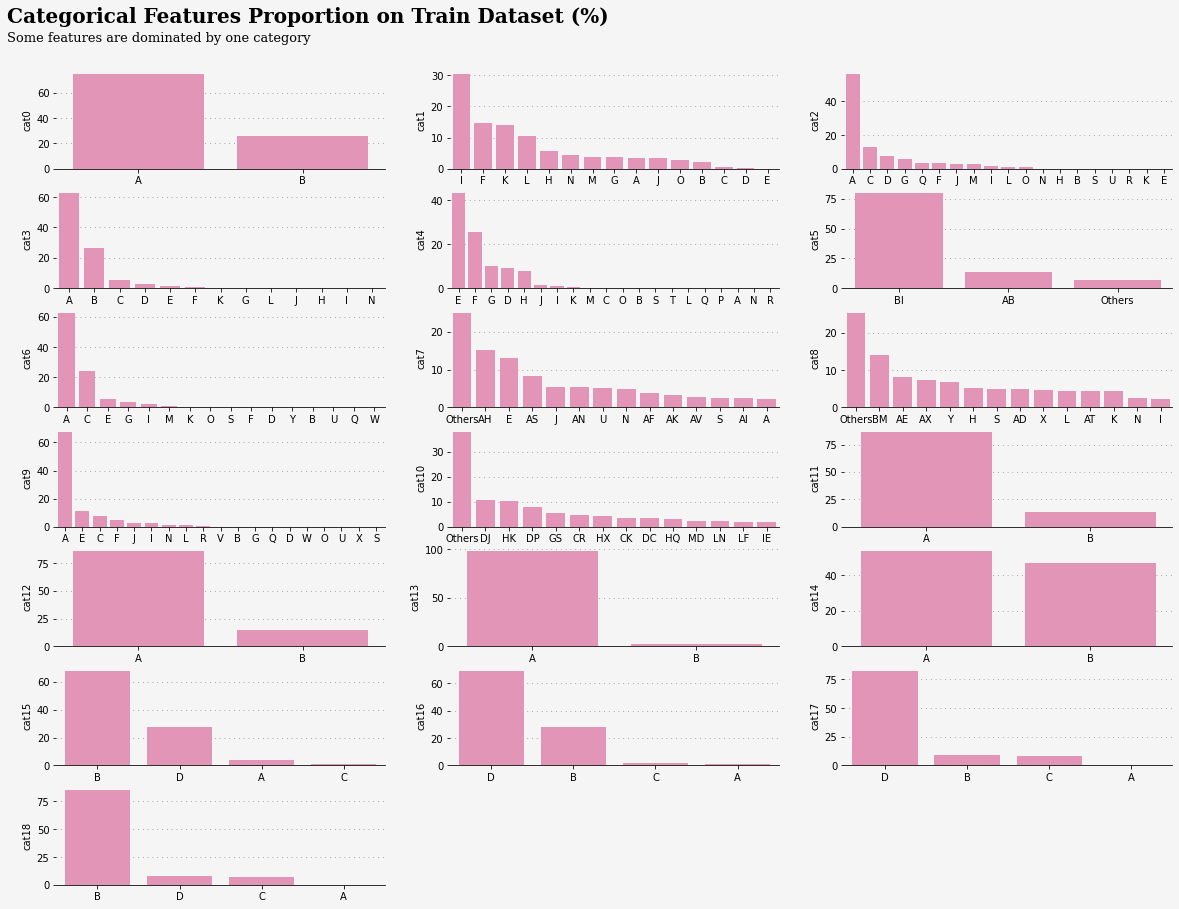

In [14]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(20, 15), facecolor=background_color)
gs = fig.add_gridspec(7, 3)
gs.update(wspace=0.2, hspace=0.2)

run_no = 0
for row in range(0, 7):
    for col in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.8, 115, 'Categorical Features Proportion on Train Dataset (%)', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.8, 100, 'Some features are dominated by one category', fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cat_features:
    chart_df = pd.DataFrame(train_df[col].value_counts() / len(train_df) * 100)
    sns.barplot(x=chart_df.index, y=chart_df[col], ax=locals()["ax"+str(run_no)], color='#f088b7', zorder=2)
    locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    run_no += 1
    
ax19.remove()
ax20.remove()

**Test dataset**

In [15]:
cat5_category = list(pd.DataFrame(test_df['cat5'].value_counts()/len(test_df['cat5'])*100)[:2].index)
cat7_category = list(pd.DataFrame(test_df['cat7'].value_counts()/len(test_df['cat7'])*100)[:13].index)
cat8_category = list(pd.DataFrame(test_df['cat8'].value_counts()/len(test_df['cat8'])*100)[:13].index)
cat10_category = list(pd.DataFrame(test_df['cat10'].value_counts()/len(test_df['cat10'])*100)[:13].index)
test_df['cat5'] = np.where(~test_df['cat5'].isin(cat5_category), 'Others', test_df['cat5'])
test_df['cat7'] = np.where(~test_df['cat7'].isin(cat7_category), 'Others', test_df['cat7'])
test_df['cat8'] = np.where(~test_df['cat8'].isin(cat8_category), 'Others', test_df['cat8'])
test_df['cat10'] = np.where(~test_df['cat10'].isin(cat10_category), 'Others', test_df['cat10'])

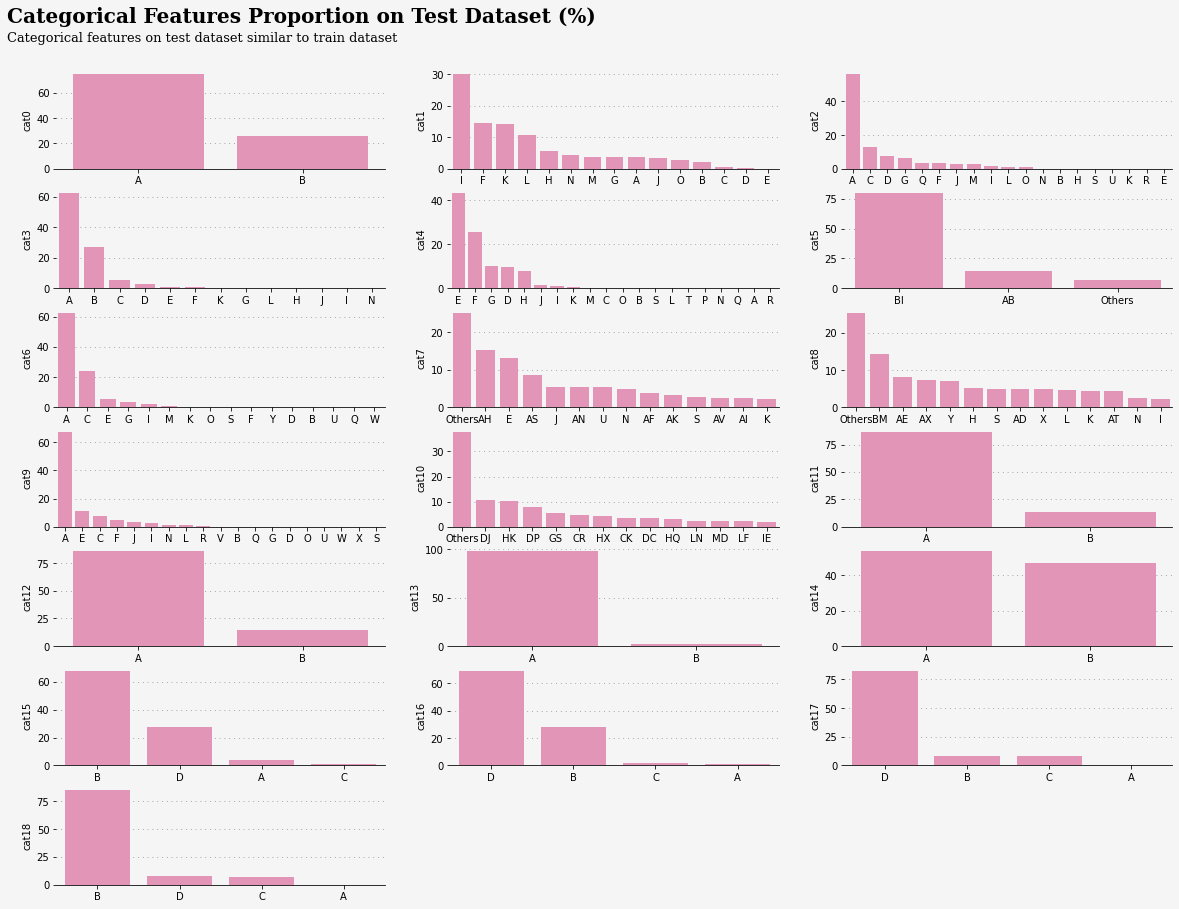

In [16]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(20, 15), facecolor=background_color)
gs = fig.add_gridspec(7, 3)
gs.update(wspace=0.2, hspace=0.2)

run_no = 0
for row in range(0, 7):
    for col in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.8, 115, 'Categorical Features Proportion on Test Dataset (%)', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.8, 100, 'Categorical features on test dataset similar to train dataset', 
         fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cat_features:
    chart_df = pd.DataFrame(test_df[col].value_counts() / len(test_df) * 100)
    sns.barplot(x=chart_df.index, y=chart_df[col], ax=locals()["ax"+str(run_no)], color='#f088b7', zorder=2)
    locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    run_no += 1
    
ax19.remove()
ax20.remove()

[back to top](#sommaire)
<a id="2.5"></a>
## 2.6. Variable cible

In [17]:
print('Propotion of target variable: 0 is', len(train_df[train_df['target']==0])/len(train_df))
print('Propotion of target variable: 1 is', len(train_df[train_df['target']==1])/len(train_df))

Propotion of target variable: 0 is 0.73513
Propotion of target variable: 1 is 0.26487


[back to top](#table-of-contents)
<a id="3"></a>
# 3. Relations entre features et variables cibles

**Observations:**
* Variables continues:
    * Variable cible: `0` est marquée par la couleur <span style='color:#facd00' > jaune </span> tandis que la valeur `1` est marquée par la couleur <span style='color:#f088b7' > rose </span>.
    * En général, il n'y a pas de distribution distincte dans les variables `continues` entre la valeur cible `0` et la valeur `1`.
* Variables catégorielles:
    * `cat0`: `A`, `cat5`: `BI`, `cat6`: `A`, `cat9`: `A`, `cat11`: `A`, `cat12`: `A`, `cat13`: `A`, `cat14`: `A`, `cat15`: `B`, `cat16`: `D`, `cat17`: `D` et `cat18`: `B` sont des catégories ayant plus de 40% de la valeur `0` de l'ensemble du train set.
    * Il n'y a pas de variables `catégorielles` qui a la valeur `1` à plus de 25% du train total.

[back to top](#sommaire)
<a id="3.1"></a>
## 3.1 Variables continues

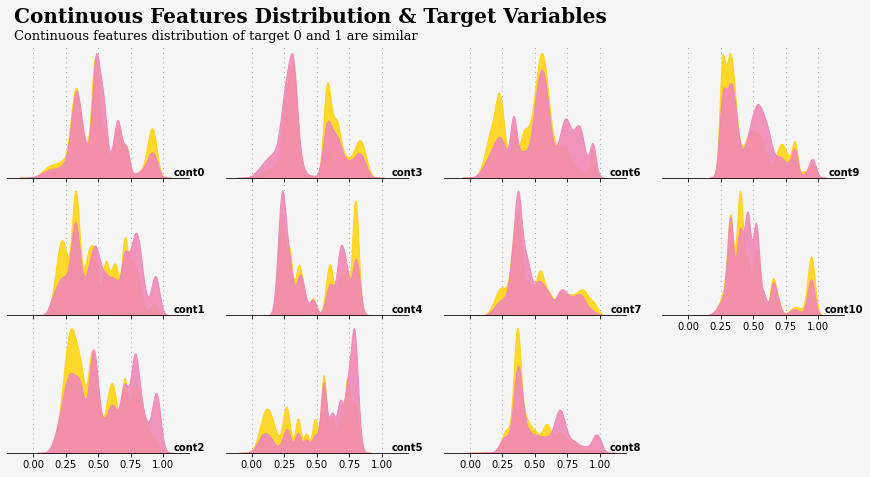

In [18]:
fig = plt.figure(figsize=(15, 10), facecolor='#f6f5f5')
gs = fig.add_gridspec(4, 4)
gs.update(wspace=0.2, hspace=0.05)

background_color = "#f6f5f5"

run_no = 0
for col in range(0, 4):
    for row in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        locals()["ax"+str(run_no)].set_yticklabels([])
        locals()["ax"+str(run_no)].tick_params(axis='y', which=u'both',length=0)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.15, 4.5, 'Continuous Features Distribution & Target Variables', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.15, 4, 'Continuous features distribution of target 0 and 1 are similar', fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cont_features:
    sns.kdeplot(train_df.loc[train_df['target'] == 0, col], ax=locals()["ax"+str(run_no)], 
                shade=True, color='#ffd514', alpha=0.9, zorder=2)
    sns.kdeplot(train_df.loc[train_df['target'] == 1, col], ax=locals()["ax"+str(run_no)], 
                shade=True, color='#f088b7', alpha=0.9, zorder=2)
    locals()["ax"+str(run_no)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    locals()["ax"+str(run_no)].set_ylabel(col, fontsize=10, fontweight='bold').set_rotation(0)
    locals()["ax"+str(run_no)].yaxis.set_label_coords(1, 0)
    locals()["ax"+str(run_no)].set_xlim(-0.2, 1.2)
    locals()["ax"+str(run_no)].set_xlabel('')
    run_no += 1
    
ax11.remove()

[back to top](#sommaire)
<a id="3.2"></a>
## 3.2 Variables catégorielles
**Cible: 0**

In [19]:
cat5_category = list(pd.DataFrame(train_df.loc[train_df['target']==0, 'cat5'].value_counts()/len(train_df['cat5'])*100)[:2].index)
cat7_category = list(pd.DataFrame(train_df.loc[train_df['target']==0, 'cat7'].value_counts()/len(train_df['cat7'])*100)[:13].index)
cat8_category = list(pd.DataFrame(train_df.loc[train_df['target']==0, 'cat8'].value_counts()/len(train_df['cat8'])*100)[:13].index)
cat10_category = list(pd.DataFrame(train_df.loc[train_df['target']==0, 'cat10'].value_counts()/len(train_df['cat10'])*100)[:13].index)
train_df['cat5'] = np.where(~train_df['cat5'].isin(cat5_category), 'Others', train_df['cat5'])
train_df['cat7'] = np.where(~train_df['cat7'].isin(cat7_category), 'Others', train_df['cat7'])
train_df['cat8'] = np.where(~train_df['cat8'].isin(cat8_category), 'Others', train_df['cat8'])
train_df['cat10'] = np.where(~train_df['cat10'].isin(cat10_category), 'Others', train_df['cat10'])

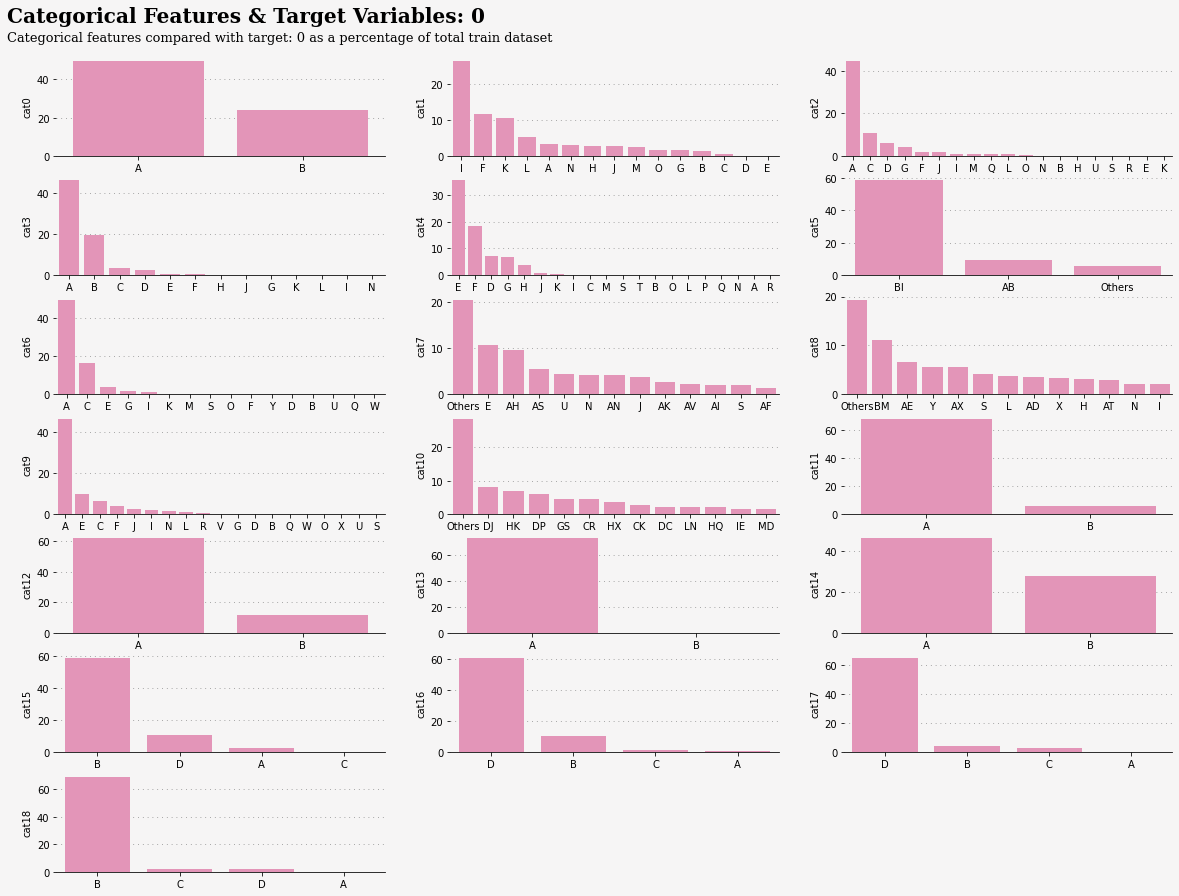

In [20]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(20, 15), facecolor=background_color)
gs = fig.add_gridspec(7, 3)
gs.update(wspace=0.2, hspace=0.2)

run_no = 0
for row in range(0, 7):
    for col in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.8, 70, 'Categorical Features & Target Variables: 0', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.8, 60, 'Categorical features compared with target: 0 as a percentage of total train dataset', 
         fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cat_features:
    chart_df = pd.DataFrame(train_df.loc[train_df['target']==0, col].value_counts() / len(train_df) * 100)
    sns.barplot(x=chart_df.index, y=chart_df[col], ax=locals()["ax"+str(run_no)], color='#f088b7', zorder=2)
    locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    run_no += 1
    
ax19.remove()
ax20.remove()

**Target: 1**

In [21]:
cat5_category = list(pd.DataFrame(train_df.loc[train_df['target']==1, 'cat5'].value_counts()/len(train_df['cat5'])*100)[:2].index)
cat7_category = list(pd.DataFrame(train_df.loc[train_df['target']==1, 'cat7'].value_counts()/len(train_df['cat7'])*100)[:13].index)
cat8_category = list(pd.DataFrame(train_df.loc[train_df['target']==1, 'cat8'].value_counts()/len(train_df['cat8'])*100)[:13].index)
cat10_category = list(pd.DataFrame(train_df.loc[train_df['target']==1, 'cat10'].value_counts()/len(train_df['cat10'])*100)[:13].index)
train_df['cat5'] = np.where(~train_df['cat5'].isin(cat5_category), 'Others', train_df['cat5'])
train_df['cat7'] = np.where(~train_df['cat7'].isin(cat7_category), 'Others', train_df['cat7'])
train_df['cat8'] = np.where(~train_df['cat8'].isin(cat8_category), 'Others', train_df['cat8'])
train_df['cat10'] = np.where(~train_df['cat10'].isin(cat10_category), 'Others', train_df['cat10'])

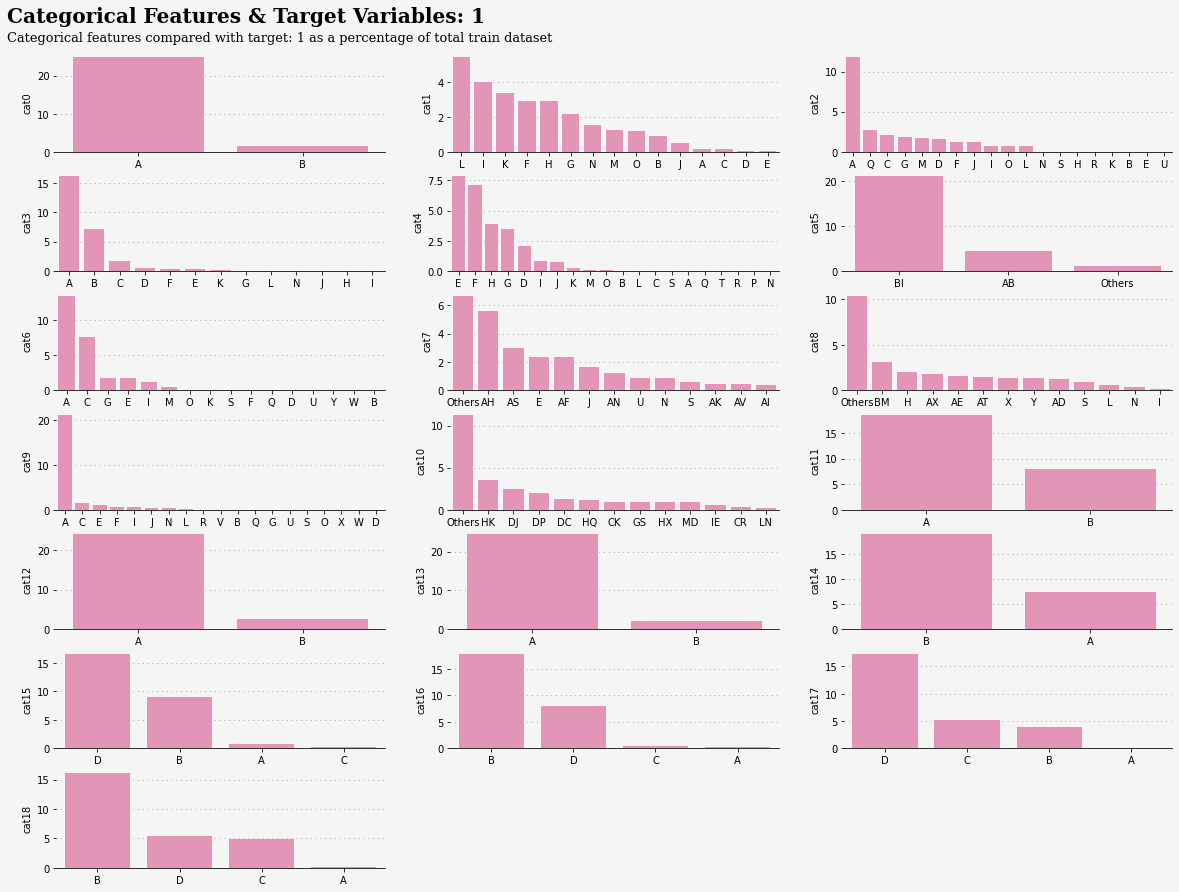

In [22]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(20, 15), facecolor=background_color)
gs = fig.add_gridspec(7, 3)
gs.update(wspace=0.2, hspace=0.2)

run_no = 0
for row in range(0, 7):
    for col in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.8, 34, 'Categorical Features & Target Variables: 1', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.8, 29
         , 'Categorical features compared with target: 1 as a percentage of total train dataset', 
         fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cat_features:
    chart_df = pd.DataFrame(train_df.loc[train_df['target']==1, col].value_counts() / len(train_df) * 100)
    sns.barplot(x=chart_df.index, y=chart_df[col], ax=locals()["ax"+str(run_no)], color='#f088b7', zorder=2)
    locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    run_no += 1
    
ax19.remove()
ax20.remove()

[back to top](#sommaire)
<a id="4"></a>
# 4. Modèle baseline

Cette section va évaluer la performance de 3 modèles : `Catboost`, `XGBoost` et `LGBM` en utilisant 3 datasets `toutes les features`, `seulement les features catégorielles` et `seulement les features continues`.. A la fin, `Un vote de classifieurs` sera utilisé pour utiliser l'ensemble des modèles.

**Observations:**
* `LGBM` a la plus haute AUC avec `0.89156` en utilisant `toutes les features` et `les features catégorielle seulement` mais les résultats sont proches de `XGBoost` et `Catboost`.
* `XGBoost` performe le mieux avec `les variables continues seulement` avec un AUC de `0.88412` et encore une fois les résultats sont proches des autres modèles.
* Ensembler les 3 modèles en les moyennant bat la baseline individuelle avec un AUC de `0.89360` avec `toutes les features`, `0.89017` avec `les features catégorielles seulement` et `0.86194` pour `les variables continues seulement`.

[back to top](#sommaire)
<a id="4.1"></a>
## 4.1 Préparation

**Etapes:**
1. Charger les `packages` pour exécuter l'encodage des labels, la cross-validation, l'apprentissage et la mesure de l'AUC.
2. Combiner le dataset `train` et `test`, le but étant de gérer les valeurs manquantes dans le `train` et le `test` lorsque nous performerons l'encodage des labels.
3. Encoder les variables `catégorielles`.
4. Re-splitter le dataset `combine` qui a été encodé en `train` et `test`.

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

In [26]:
train_df = pd.read_csv('train.csv').head(3000)
test_df = pd.read_csv('test.csv').head(1000)
combine_df = pd.concat([train_df, test_df], axis=0)
average_all_df = pd.DataFrame()
average_cat_df = pd.DataFrame()
average_cont_df = pd.DataFrame()

le = LabelEncoder()
for col in cat_features:
    combine_df[col] = le.fit_transform(combine_df[col])
train_df = combine_df.iloc[:len(train_df), :]
test_df = combine_df.iloc[len(train_df):, :]
test_df = test_df.drop('target', axis=1)

folds = 3
kf = KFold(n_splits=folds, shuffle=True, random_state=42)

features = [feature for feature in train_df.columns if feature not in ['id', 'target']]

[back to top](#sommaire)
<a id="4.2"></a>
## 4.2 Catboost

`CatBosstClassifier` est utilisé sans tuning des hyperparamètres avec un cross-validation avec K=10. 

**Observations**:
* En utilisant `toutes es features` on obtient le meilleur AUC.
* Le gap entre utiliser `seulement les var continues` et `seulement les variables catégorielles` est important.
* En-dessous son les résultats:
    * Avec `toutes les features` on obtient un OOF AUC de `0.88977`.
    * Avec les `variables catégorielles seulement` on obtient un OOF AUC de `0.88512`.
    * Avec les `variables continues seulement` on obtient un OOF AUC de `0.88512`.


**Note:** Enlevez `task_type="GPU"` et `devices="0"` pour utiliser seulement le CPU.

In [25]:
train_oof = np.zeros((3000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[features]
    X_valid = valid[features]
    y_train = train['target']
    y_valid = valid['target']

    model = CatBoostClassifier(verbose=0,
                                eval_metric="AUC",
                                random_state=42,
                                cat_features=[x for x in range(len(cat_features))],
                                )

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - All features: ', roc_auc_score(train_df['target'], train_oof))
average_all_df['catboost'] = train_oof 

Fold 0 AUC:  0.8747978747978747
Fold 1 AUC:  0.9161405212886514
Fold 2 AUC:  0.8344120510911278
Fold 3 AUC:  0.893444805367698
Fold 4 AUC:  0.9135169762972454
Fold 5 AUC:  0.8466631355932204
Fold 6 AUC:  0.9151239313610923
Fold 7 AUC:  0.8842045454545455
Fold 8 AUC:  0.88035
Fold 9 AUC:  0.9006814814814814
OOF AUC - All features:  0.8813306818181817


**Using continuous features only**

In [28]:
train_oof = np.zeros((3000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[cont_features]
    X_valid = valid[cont_features]
    y_train = train['target']
    y_valid = valid['target']

    model = CatBoostClassifier(verbose=0,
                                eval_metric="AUC",
                                random_state=42)

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - Continuous features only: ', roc_auc_score(train_df['target'], train_oof))
average_cont_df['catboost'] = train_oof 

Fold 0 AUC:  0.7521958397841716
Fold 1 AUC:  0.7955504711757454
Fold 2 AUC:  0.7831824451410659
OOF AUC - Continuous features only:  0.7743556818181818


[back to top](#sommmaire)
<a id="4.2"></a>
## 4.3 XGBoost

`XgBoostClassifier` est utilisé sans tuning des hyperparamètres avec un cross-validation avec K=10. 

**Observations**:
* En utilisant `toutes les features` on obtient le meilleur AUC.
* Le gap entre utiliser `seulement les var continues` et `seulement les variables catégorielles` est important.
* En-dessous son les résultats:
    * Avec `toutes les features` on obtient un OOF AUC de `0.88986`.
    * Avec les `variables catégorielles seulement` on obtient un OOF AUC de `0.88412`.
    * Avec les `variables continues seulement` on obtient un OOF AUC de `0.81767`.


**Note:** Enlevez `tree_method="gpu_hist"` et `gpu_id="0" pour utiliser seulement le CPU.

**Toutes les features**

In [31]:
train_oof = np.zeros((3000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[features]
    X_valid = valid[features]
    y_train = train['target']
    y_valid = valid['target']

    model = XGBClassifier(eval_metric="auc",
                          random_state=42,
                          use_label_encoder=False,)

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - All features: ', roc_auc_score(train_df['target'], train_oof))
average_all_df['xgboost'] = train_oof 

Fold 0 AUC:  0.8596093219083241
Fold 1 AUC:  0.8816001170103847
Fold 2 AUC:  0.860724764890282
OOF AUC - All features:  0.8668977272727274


**Variables catégorielles seulement**

In [35]:
train_oof = np.zeros((3000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[cat_features]
    X_valid = valid[cat_features]
    y_train = train['target']
    y_valid = valid['target']

    model = XGBClassifier(eval_metric="auc",
                          random_state=42,
                          use_label_encoder=False,)

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - Categorical features only: ', roc_auc_score(train_df['target'], train_oof))
average_cat_df['xgboost'] = train_oof 

Fold 0 AUC:  0.8399808901901272
Fold 1 AUC:  0.8575346329843916
Fold 2 AUC:  0.838294670846395
OOF AUC - Categorical features only:  0.8448730113636364


**Variable continues seulement**

In [38]:
train_oof = np.zeros((3000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[cont_features]
    X_valid = valid[cont_features]
    y_train = train['target']
    y_valid = valid['target']

    model = XGBClassifier(eval_metric="auc",
                          random_state=42,
                          use_label_encoder=False,)

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - Continuous features only: ', roc_auc_score(train_df['target'], train_oof))
average_cont_df['xgboost'] = train_oof 

Fold 0 AUC:  0.7413431028404126
Fold 1 AUC:  0.7768079149167345
Fold 2 AUC:  0.758269592476489
OOF AUC - Continuous features only:  0.7570048295454546


[back to top](#sommaire)
<a id="4.4"></a>
## 4.4 LGBM baseline

`XGBClassifier` est utilisé sans tuning des hyperparamètres avec un cross-validation avec K=10. 

**Observations**:
* En utilisant `toutes les features` on obtient le meilleur AUC.
* Le gap entre utiliser `seulement les var continues` et `seulement les variables catégorielles` est important.
* En-dessous son les résultats:
    * Avec `toutes les features` on obtient un OOF AUC de `0.89156`.
    * Avec les `variables catégorielles seulement` on obtient un OOF AUC de `0.88602`.
    * Avec les `variables continues seulement` on obtient un OOF AUC de `0.81028`.


**Note:** Enlevez `device='gpu'` pour utiliser seulement le CPU.

**Toutes les features**

In [40]:
train_oof = np.zeros((3000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[features]
    X_valid = valid[features]
    y_train = train['target']
    y_valid = valid['target']

    model = LGBMClassifier(metric="auc",
                          random_state=42,
                          cat_feature=[x for x in range(len(cat_features))])

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - All features: ', roc_auc_score(train_df['target'], train_oof))
average_all_df['lgbm'] = train_oof 

Fold 0 AUC:  0.8607436475210898
Fold 1 AUC:  0.8851522179736309
Fold 2 AUC:  0.8640652037617556
OOF AUC - All features:  0.8693647727272729


**Seulement les variables catégorielles**

In [41]:
train_oof = np.zeros((3000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[cat_features]
    X_valid = valid[cat_features]
    y_train = train['target']
    y_valid = valid['target']

    model = LGBMClassifier(metric="auc",
                          random_state=42,
                          cat_feature=[x for x in range(len(cat_features))])

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - Categorical features only: ', roc_auc_score(train_df['target'], train_oof))
average_cat_df['lgbm'] = train_oof 

Fold 0 AUC:  0.8368487208179407
Fold 1 AUC:  0.8721086942894754
Fold 2 AUC:  0.8629667711598745
OOF AUC - Categorical features only:  0.8558980113636364


**Seulement les variables continues**

In [43]:
train_oof = np.zeros((3000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[cont_features]
    X_valid = valid[cont_features]
    y_train = train['target']
    y_valid = valid['target']

    model = LGBMClassifier(metric="auc",
                          random_state=42)

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - Continuous features only: ', roc_auc_score(train_df['target'], train_oof))
average_cont_df['lgbm'] = train_oof 

Fold 0 AUC:  0.7477658384045864
Fold 1 AUC:  0.7903738063896026
Fold 2 AUC:  0.7728150470219436
OOF AUC - Continuous features only:  0.7690528409090909


[back to top](#sommaire)
<a id="4.5"></a>
## 4.5 Modèle moyenné

`Votingclassifier` est utilisé pour ensembler `Catboost`, `XGBoost` et `LGBM`. 

**Observations**:
* Comme prévu, en utilisant `toutes les features` on obtient le meilleur AUC.
* Le gap entre utiliser `seulement les var continues` et `seulement les variables catégorielles` est important.
* En-dessous son les résultats:
    * Avec `toutes les features` on obtient un OOF AUC de `0.89156`.
    * Avec les `variables catégorielles seulement` on obtient un OOF AUC de `0.88602`.
    * Avec les `variables continues seulement` on obtient un OOF AUC de `0.81028`.

In [45]:
average_all_df['average'] = average_all_df.mean(axis=1)
average_cat_df['average'] = average_cat_df.mean(axis=1)
average_cont_df['average'] = average_cont_df.mean(axis=1)

print(f'OOF AUC - All features: ', roc_auc_score(train_df['target'],average_all_df['average']))
print(f'OOF AUC - Cat features: ', roc_auc_score(train_df['target'],average_cat_df['average']))
print(f'OOF AUC - Cont features: ', roc_auc_score(train_df['target'],average_cont_df['average']))

OOF AUC - All features:  0.8737119318181819
OOF AUC - Cat features:  0.8574053977272729
OOF AUC - Cont features:  0.7747846590909091


[back to top](#sommaire)
<a id="5"></a>
# 5. Modèle fine-tuné

Nous allons ici étudier un modèle fine-tuné sur `toutes les features`. Les hyperparamètres sont pris de [TPS Mar 2021 - Stacked Starter](https://www.kaggle.com/craigmthomas/tps-mar-2021-stacked-starter) by [Craig Thomas](https://www.kaggle.com/craigmthomas)

**Observations:**
* Avec un paramétrage fin des hyperparamètres,on obtient un meilleur OOF AUC. Les modèles fine tunés de `Catboost`, `XGBoost` et `LGBM` ont un AUC qui est systématiquement supérieur de `0.005` ce qui est important en compétition d'où l'intérêt de bien fine-tuner ses modèles :
    - `Catboost` a un AUC augmenté de `0.00511`.
    - `XGBoost` a un AUC augmenté de `0.00481`.
    - `LGBM` a un AUC augmenté de `0.00533`.
* Le meilleur modèle est le modèle ensembliste fine-tuné avec un AUC`0.89689`.

In [47]:
average_tuned_df = pd.DataFrame()

In [48]:
train_oof = np.zeros((3000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[features]
    X_valid = valid[features]
    y_train = train['target']
    y_valid = valid['target']

    model = CatBoostClassifier( 
                                verbose=0,
                                eval_metric="AUC",
                                loss_function="Logloss",
                                random_state=2021,
                                num_boost_round=20000,
                                od_type="Iter",
                                od_wait=200,
                                cat_features=[x for x in range(len(cat_features))],
                                bagging_temperature=1.288692494969795,
                                grow_policy="Depthwise",
                                l2_leaf_reg=9.847870133539244,
                                learning_rate=0.01877982653902465,
                                max_depth=8,
                                min_data_in_leaf=1,
                                penalties_coefficient=2.1176668909602734)

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - All features: ', roc_auc_score(train_df['target'], train_oof))
average_tuned_df['catboost'] = train_oof

Fold 0 AUC:  0.8720102600262633
Fold 1 AUC:  0.8957824024739338
Fold 2 AUC:  0.8819811912225705
OOF AUC - All features:  0.88189375


In [49]:
train_oof = np.zeros((3000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[features]
    X_valid = valid[features]
    y_train = train['target']
    y_valid = valid['target']

    model = XGBClassifier(        
                        seed=2021,
                        n_estimators=10000,
                        verbosity=1,
                        eval_metric="auc",
                        alpha=7.105038963844129,
                        colsample_bytree=0.25505629740052566,
                        gamma=0.4999381950212869,
                        reg_lambda=1.7256912198205319,
                        learning_rate=0.011823142071967673,
                        max_bin=338,
                        max_depth=8,
                        min_child_weight=2.286836198630466,
                        subsample=0.618417952155855,
                        use_label_encoder=False)

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - All features: ', roc_auc_score(train_df['target'], train_oof))
average_tuned_df['xgboost'] = train_oof

Fold 0 AUC:  0.8738343782413864
Fold 1 AUC:  0.8922407488664618
Fold 2 AUC:  0.8772815047021942
OOF AUC - All features:  0.8807437499999999


In [50]:
train_oof = np.zeros((3000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[features]
    X_valid = valid[features]
    y_train = train['target']
    y_valid = valid['target']

    model = LGBMClassifier(
                cat_feature=[x for x in range(len(cat_features))],
                random_state=2021,
                cat_l2=25.999876242730252,
                cat_smooth=89.2699690675538,
                colsample_bytree=0.2557260109926193,
                early_stopping_round=200,
                learning_rate=0.00918685483594994,
                max_bin=788,
                max_depth=81,
                metric="auc",
                min_child_samples=292,
                min_data_per_group=177,
                n_estimators=1600000,
                n_jobs=-1,
                num_leaves=171,
                reg_alpha=0.7115353581785044,
                reg_lambda=5.658115293998945,
                subsample=0.9262904583735796,
                subsample_freq=1,
                verbose=-1)
    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - All features: ', roc_auc_score(train_df['target'], train_oof))
average_tuned_df['lgbm'] = train_oof

/Users/work/.local/share/virtualenvs/kaggle-competition-webinar-hXEaTUCF/lib/python3.9/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 0 AUC:  0.8696394173040862


/Users/work/.local/share/virtualenvs/kaggle-competition-webinar-hXEaTUCF/lib/python3.9/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 1 AUC:  0.8911281054765039


/Users/work/.local/share/virtualenvs/kaggle-competition-webinar-hXEaTUCF/lib/python3.9/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 2 AUC:  0.8809228840125392
OOF AUC - All features:  0.8791079545454545


In [51]:
average_tuned_df['average'] = average_tuned_df.mean(axis=1)
print(f'OOF AUC - All features: ', roc_auc_score(train_df['target'], average_tuned_df['average']))

OOF AUC - All features:  0.884821590909091
